# Fraud detection in online sales
We have a large dataset pertaining to online e-commerce sales, labeled as fraudulent and non-fraudulent, and our objective is to develop a machine learning solution to classify future sales based on a set of information parameters given.

## Viewing of Data
Initially, we want to observe the shape of data, frequence of the classification feature, so that we can see if we need to fill-in/exclude any data, or take any other preprocessing steps to maintain a balanced approach without over-representation, over-fitting or misleading data.

In [3]:
import pandas as pd

# load dataset
dataset = pd.read_csv('dataset/merged_dataset.csv')

# shape, types and example
print("Dataset Shape:", dataset.shape)
print("\nData Types:\n", dataset.dtypes)
print("\nFirst Rows:\n", dataset.head())

# categorical feature distribution
print("\nTransaction Fraudulence Data Distribution:\n", dataset['Is.Fraudulent'].value_counts())
print("\nSource Data Distribution:\n", dataset['source'].value_counts())
print("\nBrowser Data Distribution:\n", dataset['browser'].value_counts())
print("\nSex Data Distribution:\n", dataset['sex'].value_counts())
print("\nPayment Method Data Distribution:\n", dataset['Payment.Method'].value_counts())
print("\nProduct Category Data Distribution:\n", dataset['Product.Category'].value_counts())
print("\nDevice Used Data Distribution:\n", dataset['Device.Used'].value_counts())
print("\nAddress Match Distribution:\n", dataset['Address.Match'].value_counts())

Dataset Shape: (300000, 14)

Data Types:
 Transaction.Date       object
Transaction.Amount    float64
Customer.Age            int64
Is.Fraudulent           int64
Account.Age.Days        int64
Transaction.Hour        int64
source                 object
browser                object
sex                    object
Payment.Method         object
Product.Category       object
Quantity                int64
Device.Used            object
Address.Match           int64
dtype: object

First Rows:
       Transaction.Date  Transaction.Amount  Customer.Age  Is.Fraudulent  \
0  2024-02-12 10:05:21              145.98            29              0   
1  2024-01-25 22:24:06              677.62            40              0   
2  2024-03-26 20:32:44              798.63            40              0   
3  2024-01-07 23:14:51              314.65            34              0   
4  2024-01-19 11:01:19              119.80            11              1   

   Account.Age.Days  Transaction.Hour  source  browser sex 

### Conclusions on Viewing
We have a large dataset, with 300000 individual labeled cases, with 13 features, mixed numeric and categoric, which means we will need to encode categorical variables before modeling. <br>
We also have a 13 to 1 distribution of non-fraudulent vs fraudulent cases, which means a highly imbalaced dataset, meaning accuracy will be a misleading metric, and precision, recall and f1-score will be more expressive of the model's peformance. <br>
We might need techniques for handling imbalance, like oversampling, undersampling or class weighting in algorithms. <br>
As for the distributions of categorical data, the source, sex, payment method, product category and device used all follow pretty uniform distributions. While browser and address match over-represent Chrome and 1 respectively.

## Feature Preprocessing
Simple checking (valid values and not-null) and processing of multiple features and cleaning up of the data into a new file. We are clearly shaping our data into a desired state of values. <br>
We also maintain label encoding on Is.Fraudulent, sex and address match because it suits the format and meaning of these categories. <br>
We perform one-hot encoding on source, browser, Payment.Method, Product.Category and Device.Used, in order to not express false order, at the cost of increasing the number of features. <br>
We finally process the raw date into numeric parts fed as numbers into the model.

In [4]:
import pandas as pd

def validate_row(row):
    errors = []

    try:
        pd.to_datetime(row['Transaction.Date'])
    except Exception:
        errors.append('Invalid Transaction.Date')

    if not isinstance(row['Transaction.Amount'], (int, float)) or row['Transaction.Amount'] < 0:
        errors.append('Invalid Transaction.Amount')
    

    if row['Is.Fraudulent'] not in [0, 1]:
        errors.append('Invalid Is.Fraudulent')

    if not isinstance(row['Account.Age.Days'], (int, float)) or not (row['Account.Age.Days'] <= 0 or row['Account.Age.Days'] <= 365):
        errors.appned('Invalid Account.Age.Days')
    
    if not isinstance(row['Transaction.Hour'], (int, float)) or not (0 <= row['Transaction.Hour'] <= 23):
        errors.append('Invalid Transaction.Hour')
    
    if row['source'] not in ['Ads', 'SEO', 'Direct']:
        errors.append('Invalid source')
    
    if row['browser'] not in ['Chrome', 'Safari', 'IE', 'FireFox', 'Opera']:
        errors.append('Invalid source')

    if row['sex'] not in ['M', 'F']:
        errors.append('Invalid sex')

    if row['Payment.Method'] not in ['credit card', 'debit card', 'PayPal', 'bank transfer']:
        errors.append('Invalid Payment.Method')

    if row['Product.Category'] not in ['clothing', 'health & beauty', 'home & garden', 'electronics', 'toys & games']:
        errors.append('Invalid Product.Category')

    if not isinstance(row['Quantity'], (int, float)) or not (1 <= row['Quantity'] <= 5):
        errors.append('Invalid Quantity')

    if row['Device.Used'] not in ['mobile', 'desktop', 'tablet']:
        errors.append('Invalid Device.Used')

    if row['Address.Match'] not in [0, 1]:
        errors.append('Invalid Address.Match')

    return errors

# apply validate_row to all rows
validation_results = dataset.apply(validate_row, axis=1)

# filter into only errors
invalid_rows = dataset[validation_results.apply(lambda x: len(x) > 0)]
error_messages = validation_results[validation_results.apply(lambda x: len(x) > 0)]

# show errors
for (row, errors) in zip(invalid_rows.iterrows(), error_messages):
    index, data = row
    print(f"Row {index} has errors: {errors}")


In [10]:
import pandas as pd 
import numpy as np

# machine learning tool
from sklearn.preprocessing import LabelEncoder

# remove invalid rows
valid_dataset = dataset[validation_results.apply(lambda x: len(x) == 0)].copy()

# label encode 'sex' category
le_sex = LabelEncoder()
valid_dataset['sex'] = le_sex.fit_transform(valid_dataset['sex'])

# select one hot columns
one_hot_columns = ['source', 'browser', 'Payment.Method', 'Product.Category', 'Device.Used']

# perform automatic one-hot encoding through get_dummies
valid_dataset = pd.get_dummies(valid_dataset, columns=one_hot_columns)


# extract transaction date values 
valid_dataset['Transaction.Date'] = pd.to_datetime(valid_dataset['Transaction.Date'], format='mixed')

# create columns for date
valid_dataset['Transaction.Year'] = valid_dataset['Transaction.Date'].dt.year
valid_dataset['Transaction.Month'] = valid_dataset['Transaction.Date'].dt.month
valid_dataset['Transaction.Day'] = valid_dataset['Transaction.Date'].dt.day
valid_dataset['Transaction.Weekday'] = valid_dataset['Transaction.Date'].dt.weekday
# valid_dataset['Transaction.Hour'] = valid_dataset['Transaction.Hour'] # already exists

# perform cyclic enconding so that model understands weekday/hour proximity (e.g. 23 is close to 0)
# for days of week (0-6)
valid_dataset['Weekday_Sin'] = np.sin(2 * np.pi * valid_dataset['Transaction.Weekday'] / 7)
valid_dataset['Weekday_Cos'] = np.cos(2 * np.pi * valid_dataset['Transaction.Weekday'] / 7)

# for hour of day (0-23)
valid_dataset['Hour_Sin'] = np.sin(2 * np.pi * valid_dataset['Transaction.Hour'] / 24)
valid_dataset['Hour_Cos'] = np.cos(2 * np.pi * valid_dataset['Transaction.Hour'] / 24)

# drop redundant column
valid_dataset = valid_dataset.drop(columns=['Transaction.Date'])

# One-hot encode the Transaction.Weekday
valid_dataset = pd.get_dummies(valid_dataset, columns=['Transaction.Weekday'])

# save the prepared
valid_dataset.to_csv('dataset/prepared_dataset.csv', index=False)

## Prepare Data
Now we prepare the data for the model. We split up fraudulence from other characteristics, perform the train/test split, our objective is 80/10/10, as in training/validating/testing, so we use 0.1 test size to extract the 10% for testing. <br>
X represents the data, and y the associated labels.

In [2]:
import pandas as pd
import random

# import machine learning tool
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('dataset/prepared_dataset.csv')

# extract label and features from data
X = dataset.drop('Is.Fraudulent', axis=1)
y = dataset['Is.Fraudulent']

# perform train test split based on random number and keep balance of fraud cases in split
random_number = random.randint(0, 2147483647)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.1, 
    random_state=random_number,
    stratify=y # maintain balanced split
)

# Random Forest
Next, we create a RandomForestClassifier model and a pipeline to reach the best ammount of n_estimators and best class weight. <br>
For scoring, we could use f1 if we want to catch as many fraudulent cases as possible while maintaining high precision. <br>
We shouldn't use accuracy here, because we have an imbalanced dataset and want to catch as many fraudulent cases as possible, not maximize overall accuracy since it can make our model too conservative, or precision, because the few false positives optimization that precision intrinsically does makes it miss more fraudulent cases in exchange for few false positives. <br>
We should choose recall because typically in these types of problems, actually catching all the fraud cases and performing manual filtering of the non-fraud cases tends to be the most useful solution. <br>
In order to maintain a 80/10/10 split, we perform cross validation with 9 partitions to split up the testing/validation data into 10% chunks. <br>
We experiment with a large parameter grid and perform random search on hyperparameter configurations to find a good combination which yields the "best" estimator (within the search space of the iterations).

In [ ]:
import random
import numpy as np

# import model and pipeline tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, precision_score, classification_report, precision_recall_curve

# create the pipeline, classifier model of RandomForest
random_number = random.randint(0, 2147483647)
pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=random_number))
])

# define hyperparameter search space
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2'],       # drop 'auto'
    'classifier__bootstrap': [True],                     # only bootstrap=True
    'classifier__class_weight': ['balanced', None],      # no balanced_subsample
}


# define multiple scorings to be compared
scoring = {
  'accuracy' : 'accuracy', 
  'precision' : 'precision', 
  'recall' : 'recall', # maximizes fraud detection
  'f1' : 'f1', # balance between precision and recall -> can optimize to be good
  'roc_auc' : 'roc_auc' # separation of classes
}

random_search = RandomizedSearchCV(
    pipeline,
    param_grid,
    n_iter=40,
    cv=StratifiedKFold(n_splits=9, shuffle=True, random_state=random_number),
    scoring=scoring, # check for all relevant scorings
    refit='f1', # balance between recall -> get more fraud cases and precision
    verbose=3, # actually get information per fold
    n_jobs=-1 # use all CPU cores
)

random_search.fit(X_train, y_train)

# best parameters
print("\nBest Hyperparameters:")
print(random_search.best_params_)

# best estimator 
best_model = random_search.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]

# test thresholds
thresholds = np.linspace(0.1, 0.9, 81)
recalls = []
precisions = []

# compute precision, recall, and the thresholds
precision, recall, thresh = precision_recall_curve(y_test, y_proba)

# compute F1 at each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)

# find the index of the maximum F1
best_idx = np.nanargmax(f1_scores)
best_thresh = thresh[best_idx]

print(f"Best threshold (max F1): {best_thresh:.3f},  F1 = {f1_scores[best_idx]:.3f}")

# apply it
y_pred = (y_proba >= best_thresh).astype(int)
print(classification_report(y_test, y_pred))

Fitting 9 folds for each of 40 candidates, totalling 360 fits
[CV 8/9] END classifier__bootstrap=True, classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200; accuracy: (test=0.951) f1: (test=0.577) precision: (test=0.754) recall: (test=0.467) roc_auc: (test=0.802) total time= 1.7min
[CV 7/9] END classifier__bootstrap=True, classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200; accuracy: (test=0.952) f1: (test=0.593) precision: (test=0.772) recall: (test=0.482) roc_auc: (test=0.805) total time= 1.7min
[CV 3/9] END classifier__bootstrap=True, classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200; ac

/Users/bfmbruno/Desktop/2_semestre/Estágio/env/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 8/9] END classifier__bootstrap=True, classifier__class_weight=None, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; accuracy: (test=0.956) f1: (test=0.560) precision: (test=0.983) recall: (test=0.391) roc_auc: (test=0.790) total time= 1.8min
[CV 1/9] END classifier__bootstrap=True, classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=200; accuracy: (test=0.956) f1: (test=0.595) precision: (test=0.885) recall: (test=0.448) roc_auc: (test=0.810) total time= 1.6min
[CV 2/9] END classifier__bootstrap=True, classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=200; accuracy: (test=0.955) f1: (test=0.584) precision: (test=0.858) re

### Analysis (Random Forest)
Our binary classification model has an overall very high precision for the majority class, and a lower one for the minority class, since we are prioritizing recall over precision to catch the largest ammount of fraud cases. <br>
The recall for 0 is also much bigger, reflecting the class imbalance. <br>
The f1-score indicates that the mix between precision and recall is very good for the 0 label and mediocre for the 1 label. <br>
The dataset is heavily unbalanced, with a lot more legitimate than fraudulent cases, which makes it so that the model becomes better at identifying 0 cases than 1 cases, which is evident from the Classification Report. This iteration of the model is great at guaranteeing lack of fraud, but at identifying fraud it is not so good, only reaching less than half the cases.

## AUC and Confusion Matrix
We use the ROC-Curve and a Confusion Matrix to better visualize these results and the four possible predictions done (FN, TN, FP and TP).

AUC Score: 0.80


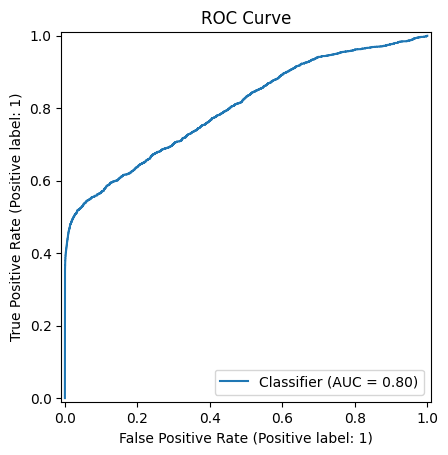

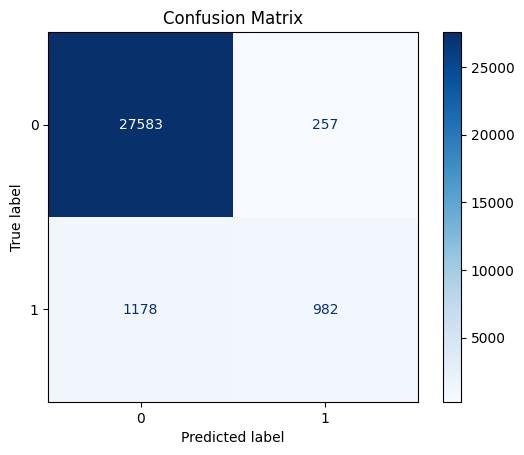

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# AUC score and ROC Curve
# for this we need predicted probabilities for class 1
y_proba = best_model.predict_proba(X_test)[:, 1] 

auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC Score: {auc_score:.2f}")

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
plt.show()

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
# plot optimal threshold chosen 

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Obter resultados da grelha
results = pd.DataFrame(random_search.cv_results_)

# Selecionar colunas relevantes
cols = ['param_classifier__class_weight', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']
summary = results[cols].groupby('param_classifier__class_weight').mean().reset_index()

# Mostrar resultados ordenados por recall
print(summary.sort_values(by='mean_test_recall', ascending=False))


  param_classifier__class_weight  mean_test_recall  mean_test_f1  \
0                       balanced          0.440635      0.564594   

   mean_test_roc_auc  
0           0.800922  


## Cross-Validation 
We perform cross-validation on the best model obtained and get the mean of each metric. For expressivity, we also print out the results per fold.

In [24]:
from sklearn.model_selection import cross_validate

# Definir as métricas que queremos avaliar
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Executar cross-validation de 9 folds sobre todo o pipeline já ajustado
cv_results = cross_validate(
    estimator=best_model,   # o melhor modelo proveniente do RandomizedSearchCV
    X=X_train,              # dados de treino (ou X completo se quiseres avaliar generalização)
    y=y_train,
    scoring=scoring,
    cv=9,
    return_train_score=False,  # só traz as métricas de validação
    n_jobs=-1
)

# Mostrar resultados médios e desvios-padrão
for metric in scoring.keys():
    scores = cv_results[f'test_{metric}']
    print(f"{metric:>10s} : {scores.mean():.4f} ± {scores.std():.4f}")


  accuracy : 0.9518 ± 0.0014
 precision : 0.7730 ± 0.0166
    recall : 0.4675 ± 0.0141
        f1 : 0.5825 ± 0.0137
   roc_auc : 0.8049 ± 0.0047


In [25]:
import pandas as pd

# Lista de métricas usadas
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Extrair as pontuações de cada fold para cada métrica
scores = {m: cv_results[f'test_{m}'] for m in metrics}

# Construir o DataFrame
cv_df = pd.DataFrame(scores, index=[f'fold_{i+1}' for i in range(len(scores['accuracy']))])

# Mostrar pontuações de cada fold
print("Pontuações por fold:\n")
print(cv_df)

# Mostrar resumo (média e desvio-padrão)
print("\nResumo (mean ± std):\n")
summary = cv_df.agg(['mean', 'std']).T
summary['mean ± std'] = summary['mean'].round(4).astype(str) + ' ± ' + summary['std'].round(4).astype(str)
print(summary[['mean ± std']])


Pontuações por fold:

        accuracy  precision    recall        f1   roc_auc
fold_1  0.952700   0.779623  0.478241  0.592826  0.813207
fold_2  0.950433   0.770281  0.443981  0.563289  0.798338
fold_3  0.950767   0.764524  0.456944  0.572008  0.797102
fold_4  0.952833   0.770516  0.491204  0.599943  0.806047
fold_5  0.951500   0.765637  0.470370  0.582736  0.806763
fold_6  0.949500   0.747886  0.450463  0.562265  0.802351
fold_7  0.951933   0.778898  0.464600  0.582029  0.805781
fold_8  0.951700   0.766867  0.473392  0.585408  0.807233
fold_9  0.954467   0.812746  0.478019  0.601981  0.807596

Resumo (mean ± std):

                mean ± std
accuracy   0.9518 ± 0.0015
precision   0.773 ± 0.0176
recall      0.4675 ± 0.015
f1         0.5825 ± 0.0145
roc_auc     0.8049 ± 0.005


# K-Nearest Neighbors (K-NN)

A **K-Nearest Neighbors** (K-NN) classifier was applied to our binary fraud detection problem. To address **class imbalance**, the pipeline included **random undersampling** of the majority class, and features were scaled using standardization.

The model was optimized using **RandomizedSearchCV** with cross-validation and multiple evaluation metrics, focusing on **maximizing the F1 score**.

**Imblearn** module was used in order to be able to test different **undersampling** ratios for the problem, as previous approaches with no undersampling had proved to be not satisfactory. 

The hyperparameter search included:

- **Number of neighbors** (n_neighbors) : `1 - 11` (odd numbers only to prevent ties)

- **Distance calculation method** (p) : `1` - Manhattan, `2` - Euclidean, `3`- Minkowski

- **Weighting strategy** : `uniform` or `distance`

- **Undersampling ratio** : `0.1-1.0`

A range of thresholds was also evaluated post-training to find the one that maximized the F1 score on the test set.

In [4]:
import random
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, precision_recall_curve
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

random_number = random.randint(0, 2147483647)

# Use imblearn pipeline to include undersampling
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=random_number)),
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

# Now define param_grid with undersample__sampling_strategy included
param_grid = {
    'undersample__sampling_strategy': [0.1, 0.25, 0.5, 0.75, 1.0],  # fraction of minority:majority after undersampling
    'classifier__n_neighbors': [1, 3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2, 3]
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=30,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_number),
    scoring=['f1', 'precision', 'recall', 'roc_auc'],
    refit='f1',
    verbose=3,
    n_jobs=-1,
    random_state=random_number
)

random_search.fit(X_train, y_train)

print("\nBest Hyperparameters:")
print(random_search.best_params_)

# Best model
best_model = random_search.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]

# Threshold search
thresholds = np.linspace(0.1, 0.9, 81)
precision, recall, thresh = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
best_idx = np.nanargmax(f1_scores)
best_thresh = thresh[best_idx]

print(f"Best threshold (max F1): {best_thresh:.3f},  F1 = {f1_scores[best_idx]:.3f}")

# Predict using best threshold
y_pred = (y_proba >= best_thresh).astype(int)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best Hyperparameters:
{'undersample__sampling_strategy': 0.25, 'classifier__weights': 'distance', 'classifier__p': 1, 'classifier__n_neighbors': 7}
Best threshold (max F1): 0.524,  F1 = 0.361
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     27840
           1       0.46      0.30      0.36      2160

    accuracy                           0.92     30000
   macro avg       0.70      0.64      0.66     30000
weighted avg       0.91      0.92      0.92     30000



Despite tuning, **recall** for the minority class (fraud) remained **low** (0.30). Although **precision** for non-fraud predictions was decent (0.95), the model **struggled** to capture a **sufficient number of fraud cases**, highlighting a key limitation of KNN in cases where fraud (minority) is sparsely distributed. 

## AUC and Confusion Matrix

The classifier achieved an ROC AUC of 0.71, indicating **moderate discriminative ability** between fraudulent and non-fraudulent transactions. While this score is **above random guessing** (0.5), it remains **below** the commonly desired threshold of 0.78 for robust fraud detection systems.

There is also an imbalance between high True Negatives and low True Positives, which confirms that the model is **biased** toward the majority class, which is typical in highly imbalanced datasets. The  relatively low recall for fraud cases shows that the model struggles to detect **fraudulent activity** — which is not desired given that we want to test for fraud, not for the lack of it.

AUC Score: 0.71


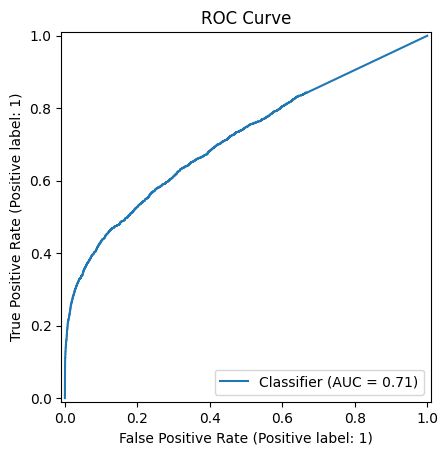

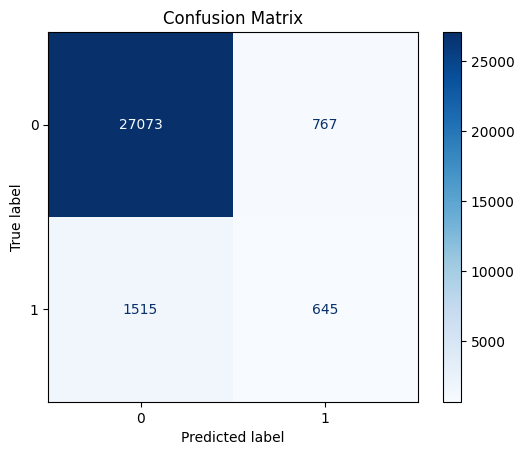

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# AUC score and ROC Curve
# for this we need predicted probabilities for class 1
y_proba = best_model.predict_proba(X_test)[:, 1] 

auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC Score: {auc_score:.2f}")

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
plt.show()

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
# plot optimal threshold chosen 

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Obter resultados da grelha
results = pd.DataFrame(random_search.cv_results_)

# Selecionar colunas relevantes
cols = ['param_classifier__weights', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']
summary = results[cols].groupby('param_classifier__weights').mean().reset_index()

# Mostrar resultados ordenados por recall
print(summary.sort_values(by='mean_test_recall', ascending=False))

  param_classifier__weights  mean_test_recall  mean_test_f1  mean_test_roc_auc
1                   uniform          0.427635      0.224092           0.658716
0                  distance          0.425716      0.222061           0.670132


## Cross-Validate

In [10]:
from sklearn.model_selection import cross_validate

# Definir as métricas que queremos avaliar
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Executar cross-validation de 5 folds sobre todo o pipeline já ajustado
cv_results = cross_validate(
    estimator=best_model,   # o melhor modelo proveniente do RandomizedSearchCV
    X=X_train,              # dados de treino (ou X completo se quiseres avaliar generalização)
    y=y_train,
    scoring=scoring,
    cv=5,
    return_train_score=False,  # só traz as métricas de validação
    n_jobs=-1
)

# Mostrar resultados médios e desvios-padrão
for metric in scoring.keys():
    scores = cv_results[f'test_{metric}']
    print(f"{metric:>10s} : {scores.mean():.4f} ± {scores.std():.4f}")

  accuracy : 0.9201 ± 0.0006
 precision : 0.4220 ± 0.0042
    recall : 0.2971 ± 0.0079
        f1 : 0.3486 ± 0.0052
   roc_auc : 0.7050 ± 0.0018


# XGBoost

**XGBoost** builds an ensemble of decision trees in a sequential way, where each new tree is trained to correct previous errors. This process focuses on minimizing a specified loss function using gradient descent optimization. This was implemented using randomized hyperparamenter search and 9 fold stratified cross validation. A custom threshold search was performed on the test to **maximize F1 score**. 

In [14]:
import random
import numpy as np
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, precision_recall_curve

# Set random seed
random_number = random.randint(0, 2147483647)

# Create pipeline (only classifier)
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_number))
])

# Hyperparameter grid for tuning
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__scale_pos_weight': [1, 5, 10, 20]  # balances fraud (rare) vs non-fraud
}

# Randomized search with Stratified CV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=30,
    cv=StratifiedKFold(n_splits=9, shuffle=True, random_state=random_number),
    scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall', 'roc_auc': 'roc_auc'},
    refit='f1',
    verbose=3,
    n_jobs=-1,
    random_state=random_number
)

# Fit model
random_search.fit(X_train, y_train)

# Output best hyperparameters
print("\nBest Hyperparameters:")
print(random_search.best_params_)

# Predict probabilities
best_model = random_search.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]

# Search for best threshold (based on F1)
thresholds = np.linspace(0.1, 0.9, 81)
precision, recall, thresh = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
best_idx = np.nanargmax(f1_scores)
best_thresh = thresh[best_idx]

print(f"Best threshold (max F1): {best_thresh:.3f},  F1 = {f1_scores[best_idx]:.3f}")

# Predict with best threshold
y_pred = (y_proba >= best_thresh).astype(int)
print(classification_report(y_test, y_pred))

Fitting 9 folds for each of 30 candidates, totalling 270 fits


C:\Users\AnaBeatrizCarneiroFe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\training.py:183: UserWarning: [10:09:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best Hyperparameters:
{'classifier__subsample': 1.0, 'classifier__scale_pos_weight': 5, 'classifier__n_estimators': 200, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.01, 'classifier__colsample_bytree': 0.8}
Best threshold (max F1): 0.581,  F1 = 0.592
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     27840
           1       0.79      0.47      0.59      2160

    accuracy                           0.95     30000
   macro avg       0.88      0.73      0.78     30000
weighted avg       0.95      0.95      0.95     30000



This XGBoost model offers a solid **balance** between precision and recall in the context of fraud detection, having improved minority class performance in comparison to the previous K-NN approach.

## AUC and Confusion Matrix

While the AUC score suggests a solid performance, the confusion matrix reveals that the recall for the minority class (fraud) is moderate.

AUC Score: 0.81


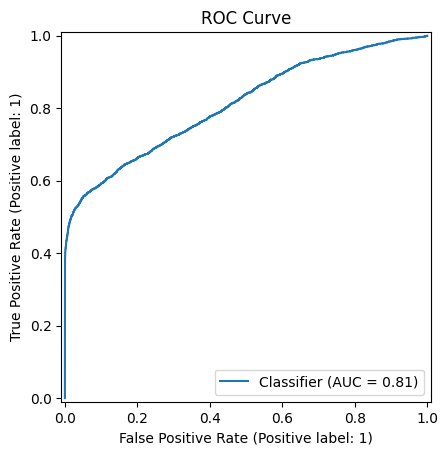

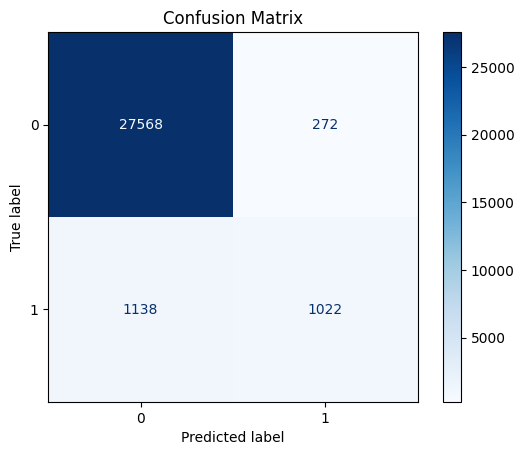

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# AUC score and ROC Curve
# for this we need predicted probabilities for class 1
y_proba = best_model.predict_proba(X_test)[:, 1] 

auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC Score: {auc_score:.2f}")

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
plt.show()

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
# plot optimal threshold chosen 

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Obter resultados da grelha
results = pd.DataFrame(random_search.cv_results_)

# Selecionar colunas relevantes
cols = ['param_classifier__scale_pos_weight', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']
summary = results[cols].groupby('param_classifier__scale_pos_weight').mean().reset_index()

# Mostrar resultados ordenados por recall
print(summary.sort_values(by='mean_test_recall', ascending=False))

   param_classifier__scale_pos_weight  mean_test_recall  mean_test_f1  \
3                                  20          0.688005      0.275699   
2                                  10          0.511518      0.535309   
1                                   5          0.486859      0.578401   
0                                   1          0.397794      0.561348   

   mean_test_roc_auc  
3           0.807065  
2           0.804393  
1           0.811168  
0           0.809028  


## Cross-Validate

In [ ]:
from sklearn.model_selection import cross_validate

# Definir as métricas que queremos avaliar
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

cv_results = cross_validate(
    estimator=best_model,   # o melhor modelo proveniente do RandomizedSearchCV
    X=X_train,              # dados de treino 
    y=y_train,
    scoring=scoring,
    cv=9,
    return_train_score=False,  # só traz as métricas de validação
    n_jobs=-1
)

# Mostrar resultados médios e desvios-padrão
for metric in scoring.keys():
    scores = cv_results[f'test_{metric}']
    print(f"{metric:>10s} : {scores.mean():.4f} ± {scores.std():.4f}")

  accuracy : 0.9498 ± 0.0010
 precision : 0.7279 ± 0.0106
    recall : 0.4830 ± 0.0105
        f1 : 0.5806 ± 0.0097
   roc_auc : 0.8115 ± 0.0046
